In [0]:
import collections
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [2]:
# !pip install Pillow==6.2.1
# import the new one
import PIL
print(PIL.PILLOW_VERSION)

4.3.0


In [0]:
from PIL import Image

# Connecting with Google Drive




In [4]:
import os
print(os.listdir("."))

['.config', 'sample_data']


In [5]:
# Authorization

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145605 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redir



---



In [0]:
# Mount drive to "drive/" folder

!mkdir -p drive
!google-drive-ocamlfuse drive

In [7]:
# Change Working directory

# COMMENTED OUT BECAUSE WE ONLY NEED TO RUN THIS ONCE
os.chdir("drive")
os.chdir("Colab Notebooks")
print(os.listdir("."))
# os.chdir("Apple")
#os.chdir("..")


['Mini Project 3', 'Thonking.jpg', 'Test Apple', 'Test Tomatoes', 'Test Pears', 'Test Grape', 'Apple', 'Grape', 'Pear', 'Tomato', 'x_train.npy', 'y_train.npy', 'x_test.npy', 'y_test.npy', 'ACM-layout-template-2018.docx', 'Final Report.desktop', 'Format Requirements for Final Project Report.pdf', 'Copy of Final Project Fruits.ipynb', 'Final Project Fruits.ipynb']


# Testing if patch works

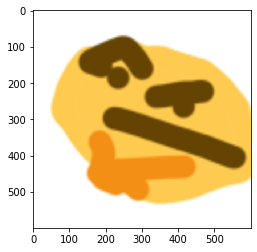

In [8]:
img = Image.open("Thonking.jpg")
plt.imshow(img)
img.load()

In [9]:
print(np.asarray(img))

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


# Begin Project

Importing Test Data

Categories

1.   Apple
2.   Grape
3.   Pear
4.   Tomato



In [0]:
os.chdir("Test Apple")
test_img = []
test_label = []

for filename in os.listdir("."):
    if filename.endswith(".jpg"):
        img = Image.open(filename)
        img.load() 
        test_img.append(np.asarray(img))
        test_label.append(0)
        continue
    else:
        continue

os.chdir("..")

In [0]:
os.chdir("Test Grape")

for filename in os.listdir("."):
    if filename.endswith(".jpg"):
        img = Image.open(filename)
        img.load() 
        test_img.append(np.asarray(img))
        test_label.append(1)
        continue
    else:
        continue

os.chdir("..")

In [0]:
os.chdir("Test Pears")
for filename in os.listdir("."):
    if filename.endswith(".jpg"):
        img = Image.open(filename)
        img.load() 
        test_img.append(np.asarray(img))
        test_label.append(2)
        continue
    else:
        continue

os.chdir("..")

In [0]:
os.chdir("Test Tomatoes")

for filename in os.listdir("."):
    if filename.endswith(".jpg"):
        img = Image.open(filename)
        img.load() 
        test_img.append(np.asarray(img))
        test_label.append(3)
        continue
    else:
        continue

os.chdir("..")

In [0]:
# print(test_list_img)
# print(test_list_label.shape)

x_test = np.asarray(test_img)
y_test = np.asarray(test_label)

print(x_test.shape)
print(y_test.shape)

(3157, 100, 100, 3)
(3157,)


# Importing Training Data

In [0]:
os.chdir("Apple")
train_img = []
train_label = []

for filename in os.listdir("."):
    if filename.endswith(".jpg"):
        img = Image.open(filename)
        img.load() 
        train_img.append(np.asarray(img))
        train_label.append(0)
        continue
    else:
        continue

os.chdir("..")

In [0]:
os.chdir("Grape")
for filename in os.listdir("."):
    if filename.endswith(".jpg"):
        img = Image.open(filename)
        img.load() 
        train_img.append(np.asarray(img))
        train_label.append(1)
        continue
    else:
        continue

os.chdir("..")

In [0]:
os.chdir("Pear")
for filename in os.listdir("."):
    if filename.endswith(".jpg"):
        img = Image.open(filename)
        img.load() 
        train_img.append(np.asarray(img))
        train_label.append(2)
        continue
    else:
        continue

os.chdir("..")

In [0]:
os.chdir("Tomato")
for filename in os.listdir("."):
    if filename.endswith(".jpg"):
        img = Image.open(filename)
        img.load() 
        train_img.append(np.asarray(img))
        train_label.append(3)
        continue
    else:
        continue

os.chdir("..")

In [0]:
x_train = np.asarray(train_img)
y_train = np.asarray(train_label)

print(x_train.shape)
print(y_train.shape)

(9118, 100, 100, 3)
(9118,)


# Save to .npy file for convenience

In [0]:
# Export to .npy ile

np.save('x_train', x_train)
np.save('y_train', y_train)
np.save('x_test', x_test)
np.save('y_test', y_test)

In [10]:
# Import from .npy file

x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

# check shape to make sure it matches initial shapes

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

(9118, 100, 100, 3)
(9118,)
(3157, 100, 100, 3)
(3157,)
9118 train samples
3157 test samples


# Normalize Training Data and reshaping(look in Mini Project 3)

In [11]:
# Convert data from int to float and normalize it

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

y_train = y_train.reshape(9118)
y_test = y_test.reshape(3157)

# Verify Shape

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(9118, 100, 100, 3)
(9118,)
(3157, 100, 100, 3)
(3157,)


In [0]:
# Convert class vectors to one hot format

import tensorflow as tf
num_classes = 4

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Begin Creating CNNs



In [13]:
# Model from Mini Project 3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

cnn_1 = Sequential()

cnn_1.add(Conv2D(128, kernel_size=(4, 6), strides=(2, 2),
                 activation='relu',
                 input_shape=(100, 100, 3)))

cnn_1.add(MaxPooling2D(pool_size=(1, 1)))

cnn_1.add(Conv2D(90, kernel_size=(6, 4), strides=(2, 2),
                 activation='sigmoid'))

cnn_1.add(MaxPooling2D(pool_size=(1, 1)))
    

cnn_1.add(Flatten())
cnn_1.add(Dense(128))
cnn_1.add(Activation("sigmoid"))
cnn_1.add(Dense(256, activation="tanh"))
# cnn_1.add(Dropout(0.5))
cnn_1.add(Dense(128, activation="sigmoid"))
# cnn_1.add(Dropout(0.5))
cnn_1.add(Dense(64, activation="relu"))
# cnn_1.add(Dropout(0.5))
cnn_1.add(Dense(32, activation="tanh"))
cnn_1.add(Dropout(0.25))
cnn_1.add(Dense(4, activation="softmax"))

# Print model summary

cnn_1.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 48, 128)       9344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 48, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 23, 90)        276570    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 23, 90)        0         
_________________________________________________________________
flatten (Flatten)            (None, 45540)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5829248   
_________________________________________

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# define optimizer and objective, compile cnn

cnn_1.compile(loss="categorical_crossentropy", optimizer="adam")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto') 

cnn_1.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)  


Train on 9118 samples, validate on 3157 samples
Epoch 1/1000
9118/9118 - 325s - loss: 1.3965 - val_loss: 1.3891
Epoch 2/1000
9118/9118 - 319s - loss: 1.3853 - val_loss: 1.3922
Epoch 3/1000
9118/9118 - 310s - loss: 1.3856 - val_loss: 1.3883
Epoch 00003: early stopping


# Results of CNN

In [16]:
from sklearn import metrics

pred1 = cnn_1.predict(x_test)
pred1 = np.argmax(pred1, axis=1)
y_true = np.argmax(y_test,axis=1)

print('CNN Model')
score = metrics.accuracy_score(y_true, pred1)
print('Accuracy: {}'.format(score))
f1 = metrics.f1_score(y_true, pred1, average='weighted')
print('Averaged F1: {}'.format(f1))

print(metrics.classification_report(y_true, pred1))

CNN Model
Accuracy: 0.2610072853975293
Averaged F1: 0.10804823067950976
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       624
           1       0.26      1.00      0.41       824
           2       0.00      0.00      0.00       832
           3       0.00      0.00      0.00       877

    accuracy                           0.26      3157
   macro avg       0.07      0.25      0.10      3157
weighted avg       0.07      0.26      0.11      3157



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 4 predictions of images from dataset

True Label: 0
Prediction: 1


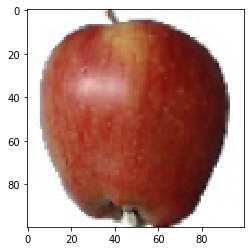

In [31]:
plt.imshow(x_test[0])

print('True Label: {}'.format(y_true[0]))
print('Prediction: {}'.format(pred1[0]))

True Label: 1
Prediction: 1


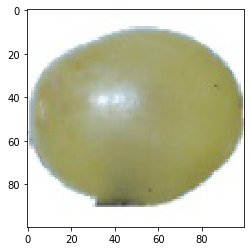

In [32]:
plt.imshow(x_test[1000])

print('True Label: {}'.format(y_true[1000]))
print('Prediction: {}'.format(pred1[1000]))

True Label: 2
Prediction: 1


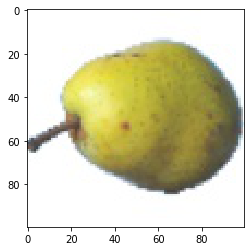

In [33]:
plt.imshow(x_test[2000])

print('True Label: {}'.format(y_true[2000]))
print('Prediction: {}'.format(pred1[2000]))

True Label: 3
Prediction: 1


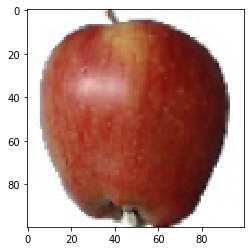

In [34]:
plt.imshow(x_test[0])

print('True Label: {}'.format(y_true[3000]))
print('Prediction: {}'.format(pred1[3000]))

# Model from Mini Project 3 didn't work quite well, so we created a different CNN




In [17]:
cnn_2 = Sequential()

cnn_2.add(Conv2D(128, kernel_size=(8, 8), strides=(2, 2),
                 activation='relu',
                 input_shape=(100, 100, 3)))

cnn_2.add(Conv2D(90, kernel_size=(4, 4), strides=(2, 2),
                 activation='relu'))

cnn_2.add(MaxPooling2D(pool_size=(1, 1)))
cnn_2.add(MaxPooling2D(pool_size=(1, 1)))
    
cnn_2.add(Dropout(0.125))

cnn_2.add(Flatten())
cnn_2.add(Activation("relu"))
cnn_2.add(Dense(150, activation="relu"))
cnn_2.add(Dense(100))
cnn_2.add(Dense(125, activation="relu"))
cnn_2.add(Activation('relu'))
cnn_2.add(Dense(4, activation="softmax"))

# Print model summary

cnn_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 47, 47, 128)       24704     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 90)        184410    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 90)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 90)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 22, 90)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 43560)             0         
_________________________________________________________________
activation_3 (Activation)    (None, 43560)            

In [18]:
cnn_2.compile(loss="categorical_crossentropy", optimizer="adam")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto') 

cnn_2.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)  

Train on 9118 samples, validate on 3157 samples
Epoch 1/1000
9118/9118 - 253s - loss: 0.1339 - val_loss: 0.4309
Epoch 2/1000
9118/9118 - 253s - loss: 0.0658 - val_loss: 0.3851
Epoch 3/1000
9118/9118 - 254s - loss: 0.0050 - val_loss: 0.2520
Epoch 4/1000
9118/9118 - 251s - loss: 7.3128e-04 - val_loss: 0.3268
Epoch 5/1000
9118/9118 - 253s - loss: 5.4098e-05 - val_loss: 0.3699
Epoch 00005: early stopping


In [19]:
pred2 = cnn_2.predict(x_test)
pred2 = np.argmax(pred2, axis=1)
y_true = np.argmax(y_test,axis=1)

print('CNN Model')
score = metrics.accuracy_score(y_true, pred2)
print('Accuracy: {}'.format(score))
f1 = metrics.f1_score(y_true, pred2, average='weighted')
print('Averaged F1: {}'.format(f1))

print(metrics.classification_report(y_true, pred2))

CNN Model
Accuracy: 0.9382324992081089
Averaged F1: 0.9386695047221433
              precision    recall  f1-score   support

           0       0.78      0.97      0.87       624
           1       1.00      0.80      0.89       824
           2       0.97      0.98      0.98       832
           3       1.00      1.00      1.00       877

    accuracy                           0.94      3157
   macro avg       0.94      0.94      0.93      3157
weighted avg       0.95      0.94      0.94      3157



True Label: 0
Prediction: 0


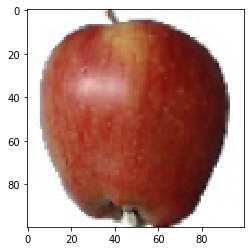

In [20]:
plt.imshow(x_test[0])

print('True Label: {}'.format(y_true[0]))
print('Prediction: {}'.format(pred2[0]))

True Label: 1
Prediction: 1


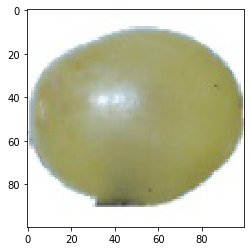

In [21]:
plt.imshow(x_test[1000])

print('True Label: {}'.format(y_true[1000]))
print('Prediction: {}'.format(pred2[1000]))

True Label: 2
Prediction: 2


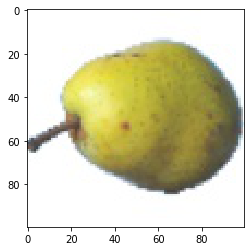

In [22]:
plt.imshow(x_test[2000])

print('True Label: {}'.format(y_true[2000]))
print('Prediction: {}'.format(pred2[2000]))

True Label: 3
Prediction: 3


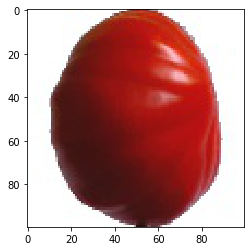

In [23]:
plt.imshow(x_test[3000])

print('True Label: {}'.format(y_true[3000]))
print('Prediction: {}'.format(pred2[3000]))

# Attempting to recreate CNN used in original dataset
 

*   Original neural network used 3D instead of 2D so we had to slightly adapt




In [24]:
cnn_3 = Sequential()

cnn_3.add(Conv2D(16, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=(100, 100, 3)))
cnn_3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 1)))

cnn_3.add(Conv2D(32, kernel_size=(4, 4),
                 activation='relu'))
cnn_3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 1)))

cnn_3.add(Conv2D(64, kernel_size=(4, 4),
                 activation='relu'))
cnn_3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 1)))

cnn_3.add(Conv2D(128, kernel_size=(4, 4),
                 activation='relu'))
cnn_3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 1)))

cnn_3.add(Flatten())

cnn_3.add(Dense(49))
cnn_3.add(Dense(256))
cnn_3.add(Dense(4, activation="softmax"))

# Print model summary

cnn_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 97, 97, 16)        784       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 96, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45, 93, 32)        8224      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 22, 92, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 89, 64)        32832     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 88, 64)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 85, 128)       

In [25]:
cnn_3.compile(loss="categorical_crossentropy", optimizer="adam")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto') 

cnn_3.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)  

Train on 9118 samples, validate on 3157 samples
Epoch 1/1000
9118/9118 - 320s - loss: 0.1457 - val_loss: 0.5024
Epoch 2/1000
9118/9118 - 321s - loss: 0.0083 - val_loss: 0.9838
Epoch 3/1000
9118/9118 - 315s - loss: 0.0288 - val_loss: 0.5105
Epoch 00003: early stopping


In [26]:
pred3 = cnn_3.predict(x_test)
pred3 = np.argmax(pred3, axis=1)
y_true = np.argmax(y_test,axis=1)

print('CNN Model')
score = metrics.accuracy_score(y_true, pred3)
print('Accuracy: {}'.format(score))
f1 = metrics.f1_score(y_true, pred3, average='weighted')
print('Averaged F1: {}'.format(f1))

print(metrics.classification_report(y_true, pred3))

CNN Model
Accuracy: 0.9116249604054482
Averaged F1: 0.9132586929991344
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       624
           1       1.00      0.80      0.89       824
           2       0.91      0.93      0.92       832
           3       1.00      1.00      1.00       877

    accuracy                           0.91      3157
   macro avg       0.91      0.91      0.91      3157
weighted avg       0.92      0.91      0.91      3157



True Label: 0
Prediction: 0


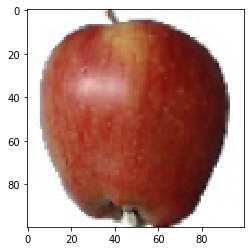

In [27]:
plt.imshow(x_test[0])

print('True Label: {}'.format(y_true[0]))
print('Prediction: {}'.format(pred3[0]))

True Label: 1
Prediction: 1


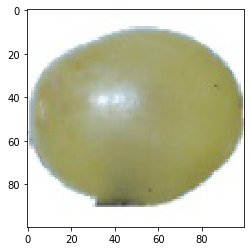

In [28]:
plt.imshow(x_test[1000])

print('True Label: {}'.format(y_true[1000]))
print('Prediction: {}'.format(pred3[1000]))

True Label: 2
Prediction: 2


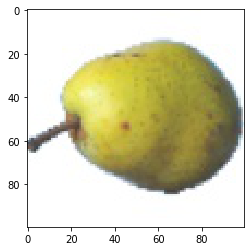

In [29]:
plt.imshow(x_test[2000])

print('True Label: {}'.format(y_true[2000]))
print('Prediction: {}'.format(pred3[2000]))

True Label: 3
Prediction: 3


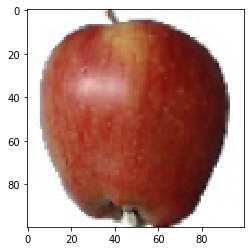

In [30]:
plt.imshow(x_test[0])

print('True Label: {}'.format(y_true[3000]))
print('Prediction: {}'.format(pred3[3000]))

# Begin Transfer Learning

In [0]:
# Load Data Again

# Import from .npy file

x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

# check shape to make sure it matches initial shapes

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

(9118, 100, 100, 3)
(9118,)
(3157, 100, 100, 3)
(3157,)
9118 train samples
3157 test samples


In [0]:
import skimage.transform

new_x_train = []

for image in x_train:
  newImage = skimage.transform.resize(image, (64, 64))      # note that resize() also normalizes your image
  new_x_train.append(newImage)

new_x_train = np.asarray(new_x_train)
  
new_x_test = []

for image in x_test:
  newImage = skimage.transform.resize(image, (64, 64))
  new_x_test.append(newImage)

new_x_test = np.asarray(new_x_test)


# Applying one hot encoding 
y_train = tf.keras.utils.to_categorical(y_train, 4)
y_test = tf.keras.utils.to_categorical(y_test, 4)

# Load Pre-trained model

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer

model = Sequential()

for layer in vgg_model.layers:
  model.add(layer)

# print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

# Freeze weights of each layer

In [0]:
for layer in model.layers:
  layer.trainable = False

# Adding Dense layers and output layer, then compiling and fit

In [0]:
model.add(Flatten())


# Add some "Dense" layers here, including output layer


model.add(Dense(40))
model.add(Dense(20, activation='relu'))
model.add(Dense(30))
model.add(Dense(5, activation='sigmoid'))

model.add(Dense(4, activation='softmax')) # output layer

model.compile(loss="categorical_crossentropy", optimizer="adam")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto') 

model.fit(new_x_train, y_train, validation_data=(new_x_test, y_test), callbacks=[monitor], verbose=2, epochs=1000) 



Train on 9118 samples, validate on 3157 samples
Epoch 1/1000
9118/9118 - 500s - loss: 0.9463 - val_loss: 0.7251
Epoch 2/1000
9118/9118 - 502s - loss: 0.5073 - val_loss: 0.5233
Epoch 3/1000
9118/9118 - 503s - loss: 0.3469 - val_loss: 0.3327
Epoch 4/1000
9118/9118 - 503s - loss: 0.2292 - val_loss: 0.2367
Epoch 5/1000
9118/9118 - 501s - loss: 0.1584 - val_loss: 0.1767
Epoch 6/1000
9118/9118 - 500s - loss: 0.1158 - val_loss: 0.1419
Epoch 7/1000
9118/9118 - 501s - loss: 0.0879 - val_loss: 0.1194
Epoch 8/1000
9118/9118 - 500s - loss: 0.0685 - val_loss: 0.0958
Epoch 9/1000
9118/9118 - 500s - loss: 0.0545 - val_loss: 0.0838
Epoch 10/1000
9118/9118 - 501s - loss: 0.0441 - val_loss: 0.0790
Epoch 11/1000
9118/9118 - 499s - loss: 0.0361 - val_loss: 0.0652
Epoch 12/1000
9118/9118 - 499s - loss: 0.0299 - val_loss: 0.0596
Epoch 13/1000
9118/9118 - 498s - loss: 0.0250 - val_loss: 0.0579
Epoch 14/1000
9118/9118 - 499s - loss: 0.0210 - val_loss: 0.0554
Epoch 15/1000
9118/9118 - 499s - loss: 0.0178 - val

In [0]:
from sklearn import metrics

pred = model.predict(new_x_test)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test,axis=1)

print('Transfer Learning Model')
score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))
f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

print(metrics.classification_report(y_true, pred))

Transfer Learning Model
Accuracy: 0.982895153626861
Averaged F1: 0.9829187029272352
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       624
           1       1.00      0.98      0.99       824
           2       1.00      0.96      0.98       832
           3       0.95      1.00      0.98       877

    accuracy                           0.98      3157
   macro avg       0.98      0.98      0.98      3157
weighted avg       0.98      0.98      0.98      3157



True Label: 0
Prediction: 0


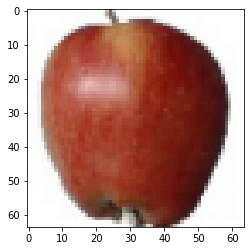

In [0]:
plt.imshow(new_x_test[0])

print('True Label: {}'.format(y_true[0]))
print('Prediction: {}'.format(pred[0]))

True Label: 1
Prediction: 1


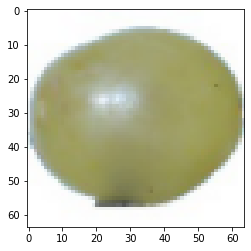

In [0]:
plt.imshow(new_x_test[1000])

print('True Label: {}'.format(y_true[1000]))
print('Prediction: {}'.format(pred[1000]))

True Label: 2
Prediction: 2


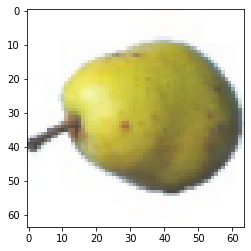

In [0]:
plt.imshow(new_x_test[2000])

print('True Label: {}'.format(y_true[2000]))
print('Prediction: {}'.format(pred[2000]))

True Label: 3
Prediction: 3


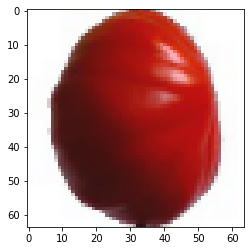

In [0]:
plt.imshow(new_x_test[3000])

print('True Label: {}'.format(y_true[3000]))
print('Prediction: {}'.format(pred[3000]))